In [ ]:
#### Imports

In [44]:
# data representation and ops
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr

# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# GIS 
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.enums import Resampling

# date/time
from datetime import datetime, date

# stats
from scipy import stats
from scipy.stats import shapiro, kstest 
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL, DecomposeResult
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# helpers/locals
import src.da.stats as dastats


#### Rainfall data

In [2]:
rain_xr = xr.open_zarr('data/nasa/rainfall/')
rain_xr = rain_xr.load()
rain_xr = rain_xr.PRECTOT

# rainfall units in kg m-2 h-1
rain_xr = rain_xr * 3600
rain_xr.attrs['units'] = f'kg m-2 h-1'  
    
rain_xr

/home/creator/anaconda3/envs/tensorflow/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'PRECTOT' (time: 140, lat: 361, lon: 576)>
array([[[0.00502315, 0.00502315, 0.00502315, ..., 0.00502315,
         0.00502315, 0.00502315],
        [0.00490883, 0.00490848, 0.00490814, ..., 0.00490972,
         0.00490942, 0.00490907],
        [0.00479849, 0.00480313, 0.00480775, ..., 0.00478432,
         0.00478893, 0.00479371],
        ...,
        [0.02860569, 0.02860701, 0.0286091 , ..., 0.02859838,
         0.02860104, 0.02860371],
        [0.02725257, 0.02725555, 0.02725791, ..., 0.02724507,
         0.02724737, 0.02725014],
        [0.02580802, 0.02580802, 0.02580802, ..., 0.02580802,
         0.02580802, 0.02580802]],

       [[0.0047389 , 0.0047389 , 0.0047389 , ..., 0.0047389 ,
         0.0047389 , 0.0047389 ],
        [0.0048689 , 0.00487397, 0.00487894, ..., 0.00485337,
         0.0048586 , 0.00486377],
        [0.00505092, 0.00506817, 0.00508556, ..., 0.00499959,
         0.00501667, 0.00503368],
...
        [0.02710734, 0.02705632, 0.0270067 , ..., 0.02726815,
         0.02721353, 0.02716022],
        [0.03153668, 0.03151636, 0.03149623, ..., 0.0316021 ,
         0.03157941, 0.0315589 ],
        [0.03515996, 0.03515996, 0.03515996, ..., 0.03515996,
         0.03515996, 0.03515996]],

       [[0.00366877, 0.00366877, 0.00366877, ..., 0.00366877,
         0.00366877, 0.00366877],
        [0.00411793, 0.00412063, 0.00412321, ..., 0.00410908,
         0.00411215, 0.0041151 ],
        [0.00489193, 0.00490317, 0.00491416, ..., 0.00485734,
         0.00486902, 0.00488056],
        ...,
        [0.0249111 , 0.02500342, 0.02509743, ..., 0.0246426 ,
         0.02473092, 0.02482009],
        [0.02921424, 0.02923789, 0.02926241, ..., 0.02914413,
         0.02916745, 0.02919036],
        [0.03239077, 0.03239077, 0.03239077, ..., 0.03239077,
         0.03239077, 0.03239077]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2011-01-01T00:30:00 ... 2023-01-01T00:30:00
Attributes:
    units:    kg m-2 h-1

In [3]:
# select a 60km x 60km ~ 30' x 30' (1' = 1NM = 1.852)
rain_xrbox = rain_xr.sel(lat=slice(47.,47.5), lon=slice(16., 17.))

rain_xrbox = rain_xrbox.coarsen(lat=2).sum().coarsen(lon=2).sum() * 24 
rain_xrbox.attrs['units'] = 'kg m-2 24h'

rdf_box = rain_xrbox.to_dataframe()

# a complicated way of dropping levels
# rdf_box = rdf_box.xs((slice(None),slice(None)), level=['lat','lon'], axis=0, drop_level=True) 

# easier way of dropping levels
rdf_box.index = rdf_box.index.droplevel(['lat','lon'])
rdf_box.rename_axis('date', inplace=True)
rdf_box.rename(columns={'PRECTOT':'rainfall'}, inplace=True)

rdf_box.describe()

,rainfall
count,140.000000
mean,8.827963
std,5.155241
min,0.599691
25%,5.140165
50%,7.927649
75%,11.490382
max,29.017860


#### Visualization

array([<AxesSubplot:title={'center':'rainfall'}>], dtype=object)

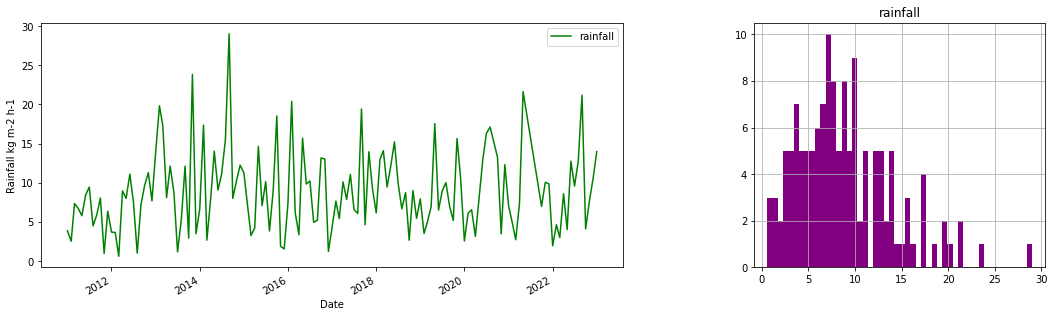

In [4]:
# Basic
fig, ax = plt.subplots(1,2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

rdf_box.plot(ax=ax[0], 
             ylabel=f'Rainfall {rain_xr.attrs["units"]}', 
             xlabel='Date',
             color='green')

rdf_box.hist(bins=50, ax=ax[1], color='purple')

/tmp/ipykernel_20288/275136443.py:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  rdf_box2['rainfall_mean'] = rdf_box2['rainfall'].fillna(rdf_box2.mean())


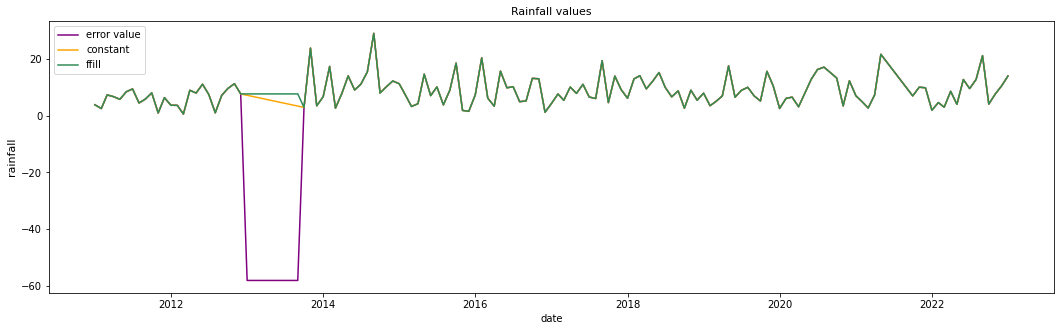

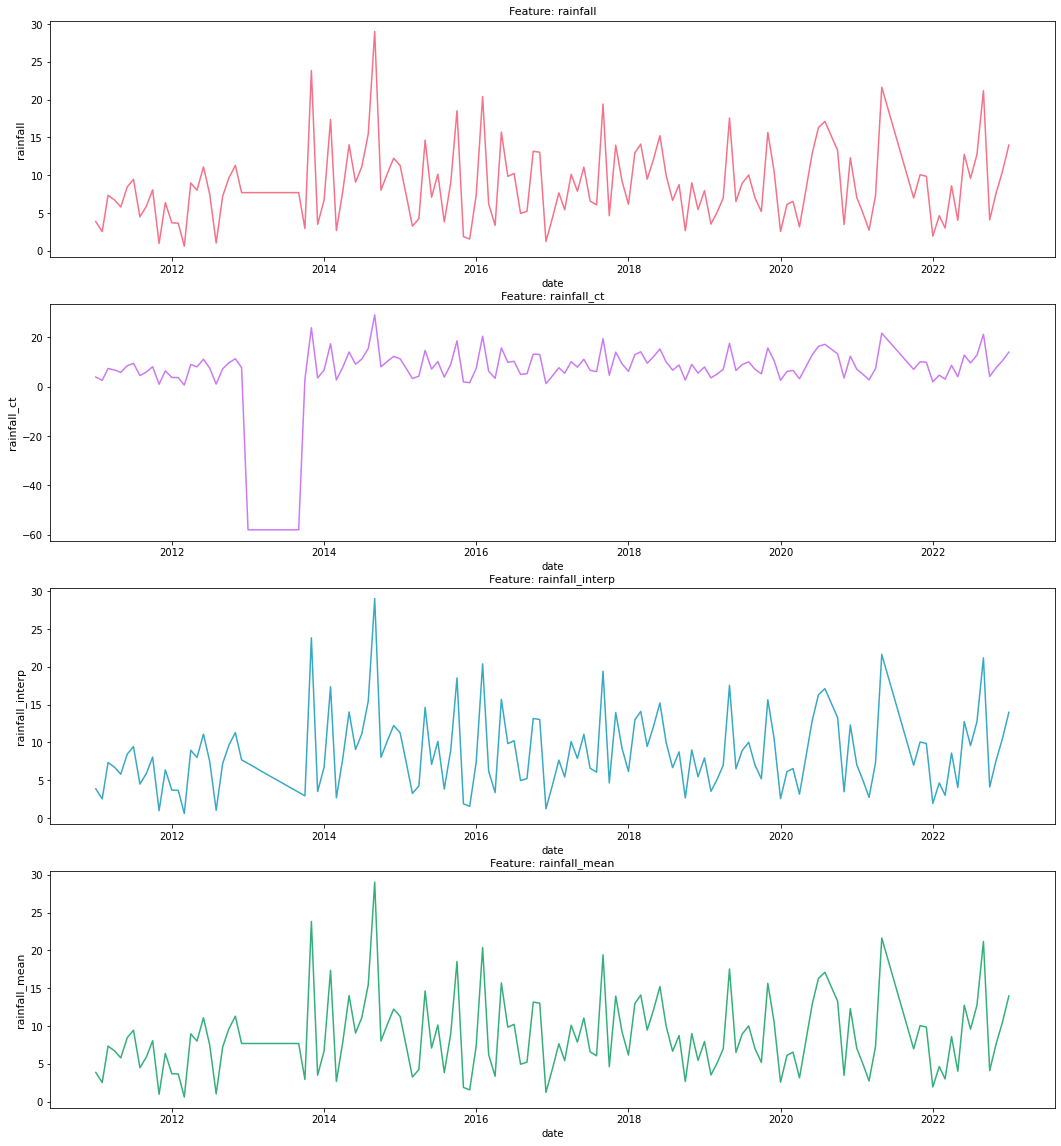

In [5]:
# viz using seaborn - also in this case for future use: 

# 0. artificially create some missing data
rdf_box2 = rdf_box.copy()
error_value = rdf_box2.max()[0] * -2

rdf_box2.loc[slice('2013-01-01','2013-09-01'),'rainfall'] = error_value
rdf_box2 = rdf_box2.reset_index(level=['date',])

# 1. check for missing data
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))

old_rain = rdf_box2['rainfall'].copy()
rdf_box2['rainfall'] = rdf_box2['rainfall'].replace(error_value, np.nan)

sns.lineplot(x=rdf_box2['date'], y=old_rain, ax=ax, color='purple', label='error value')
sns.lineplot(x=rdf_box2['date'], y=rdf_box2['rainfall'].fillna(np.inf), ax=ax, color='orange', label='constant')
sns.lineplot(x=rdf_box2['date'], y=rdf_box2['rainfall'].fillna(method='ffill'), ax=ax, color='seagreen', label='ffill')
ax.set_title('Rainfall values', fontsize=11)
ax.set_ylabel(ylabel='rainfall', fontsize=11)

# plot all columns and fill na data
rdf_box2['rainfall_ct'] = rdf_box2['rainfall'].fillna(error_value)
rdf_box2['rainfall_interp'] = rdf_box2['rainfall'].interpolate() # other fillna methods: use a constant, use the mean value, or ffill
rdf_box2['rainfall_mean'] = rdf_box2['rainfall'].fillna(rdf_box2.mean())

rdf_box2cols = rdf_box2.drop('date',axis=1).columns

_, ax = plt.subplots(nrows=rdf_box2cols.shape[0], ncols=1, figsize=(18, 20))

palete = sns.color_palette('husl',5)
for i, column in enumerate(rdf_box2cols):
    
    sel_ax, column = (ax[i],column) if rdf_box2.columns.shape[0] > 1 else (ax,'rainfall')
    
    sns.lineplot(x=rdf_box2['date'],y=rdf_box2[column].fillna(method='ffill'), ax=sel_ax, color=palete[-i])
   
    sel_ax.set_title('Feature: {}'.format(column), fontsize=11) 
    sel_ax.set_ylabel(ylabel=column, fontsize=11)

# reset to full data
rdf_box2 = rdf_box.copy()
rdf_box2 = rdf_box2.reset_index(level=['date',])

#### (Pre)processing

Up/Down sampling

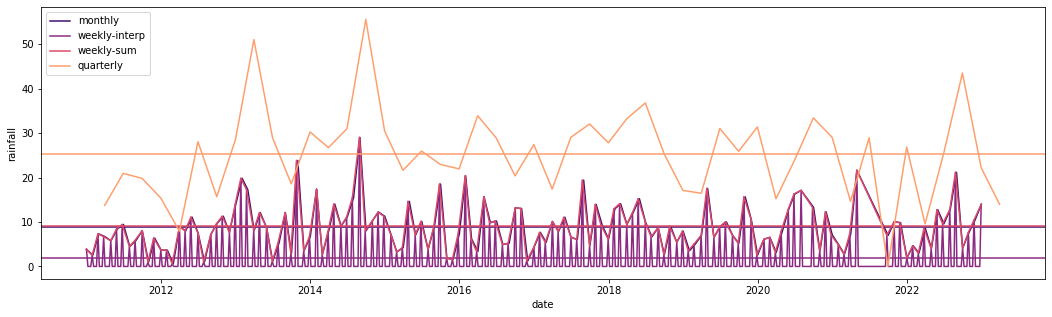

In [6]:
_, ax = plt.subplots(figsize=(18, 5))
#### (Pre)processing
upsample = rdf_box2[['date','rainfall']].resample('7D', on='date').sum().reset_index(drop=False)
upsample_viz = rdf_box2[['date','rainfall']].resample('7D', on='date').mean().interpolate().reset_index(drop=False)
dnsample = rdf_box2[['date','rainfall']].resample('Q', on='date').sum().reset_index(drop=False)

p = sns.color_palette('magma',4)

for i,(d,l) in enumerate(zip([rdf_box2, upsample, upsample_viz, dnsample],['monthly','weekly-interp','weekly-sum','quarterly'])):
    sns.lineplot(x=d['date'], y=d['rainfall'], ax=ax, color=p[i], label=l).axhline(d.rainfall.mean(),color=p[i])


Distribution evaluation & transformation

Text(0.5, 1.0, 'Singal smoothing towards normal dist')

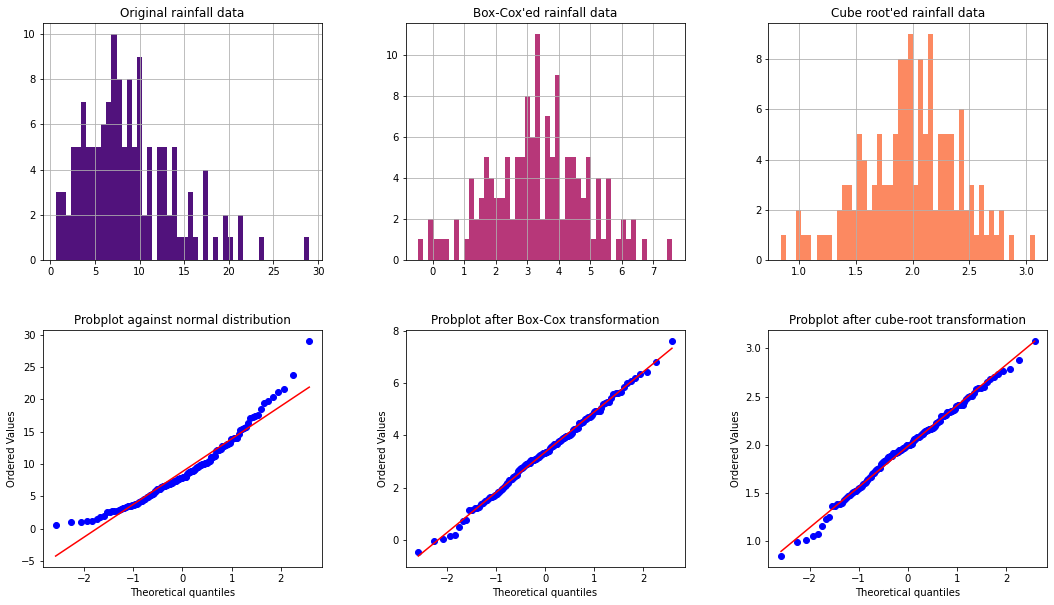

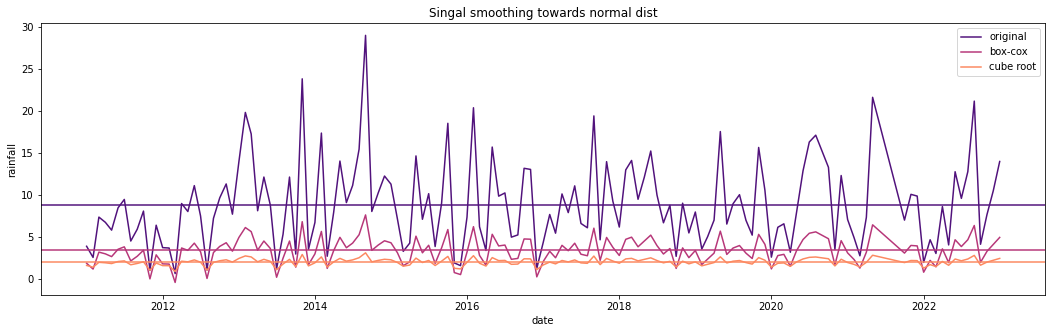

In [7]:
fig, ax = plt.subplots(2,3, figsize=(18, 10), gridspec_kw={'width_ratios': [1, 1, 1]})

# Transformations
### box-cox
rdf_boxcox = rdf_box.copy()
rdf_boxcox['rainfall'], maxlog = stats.boxcox(rdf_box.rainfall)


### cube root
rdf_boxcube = rdf_box.copy()
rdf_boxcube['rainfall'] = np.power(rdf_boxcube.rainfall,1/3)

### Histograms
p = sns.color_palette('magma',3)
rdf_box.hist(bins=50, ax=ax[0,0], color=p[0])
rdf_boxcox.hist(bins=50, ax=ax[0,1], color=p[1])
rdf_boxcube.hist(bins=50, ax=ax[0,2], color=p[2])

ax[0,0].set_title('Original rainfall data')
ax[0,1].set_title('Box-Cox\'ed rainfall data')
ax[0,2].set_title('Cube root\'ed rainfall data')

### Q-Q plots
stats.probplot(rdf_box.rainfall, dist=stats.norm, plot=ax[1,0])
stats.probplot(rdf_boxcox.rainfall, dist=stats.norm, plot=ax[1,1])
stats.probplot(rdf_boxcube.rainfall, dist=stats.norm, plot=ax[1,2])
[ax.set_label('') for ax in ax[1]]
ax[1,0].set_title('Probplot against normal distribution')
ax[1,1].set_title('Probplot after Box-Cox transformation')
ax[1,2].set_title('Probplot after cube-root transformation')


### Line plots 
_, ax = plt.subplots(figsize=(18, 5))
p = sns.color_palette('magma',3)

for i,(d,l) in enumerate(zip([rdf_box, rdf_boxcox, rdf_boxcube],['original','box-cox','cube root'])):
    sns.lineplot(x=d.index, y=d.rainfall, ax=ax, color=p[i], label=l).axhline(d.rainfall.mean(),color=p[i])
ax.set_title('Singal smoothing towards normal dist')

Testing for normality

,test-statistics,p-value,tests-transforms
0,0.945185,2.538306e-05,[Shapiro] original
1,0.996488,9.844083e-01,[Shapiro] box-cox
2,0.993914,8.193392e-01,[Shapiro] ^1/3
3,0.937064,1.401810e-168,[K-S] original
4,0.823770,3.516652e-105,[K-S] box-cox
5,0.856200,4.671703e-118,[K-S] ^1/3


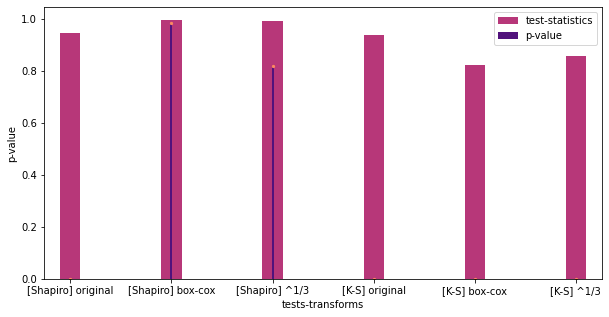

In [8]:
combo_fn = lambda normality_res: dict(zip(['test-statistics','p-value'], normality_res))
                                      
normality_results = {'Shapiro':{'original': shapiro(rdf_box.rainfall),
                                'box-cox' : shapiro(rdf_boxcox.rainfall),
                                '^1/3'    : shapiro(rdf_boxcube.rainfall)},
                     'K-S'    :{'original': kstest(rdf_box.rainfall,'norm'), 
                                'box-cox' : kstest(rdf_boxcox.rainfall,'norm'),
                                '^1/3'    : kstest(rdf_boxcube.rainfall,'norm')}}
def walk(node):
    if type(node) is dict:
        return {k: walk(v) for k, v in node.items()}
    else:
        return combo_fn(node)
                                                              
normality_results = walk(normality_results)


# combo_fn(shapiro(rdf_box.rainfall))
normality_results = pd.DataFrame.from_dict({(i,j): normality_results[i][j]
                                                for i in normality_results.keys() 
                                                for j in normality_results[i].keys()
                                                },
                                            orient='index')

_, ax = plt.subplots(figsize=(10, 5))

# normality_results.plot(kind='scatter',x='',y='',ax=ax)

# normality_results.loc[(slice(None),slice(None),'test-statistics'),:].plot(kind='barh',ax=ax, color=p[0], label='test-statistics')
# normality_results.loc[(slice(None),slice(None),'p-value'),:].plot(kind='barh',ax=ax, color=p[1], label='p-value')

normality_results.reset_index(inplace=True)
normality_results['tests-transforms'] = '[' + normality_results['level_0'] + '] ' + normality_results['level_1']
normality_results.drop(columns=['level_0','level_1'], inplace=True)

# normality_results.plot.scatter(x=['level_0','level_1'],y='level_1')
normality_results.plot.bar(x='tests-transforms',y='test-statistics',ax=ax,color=p[1],width=0.2)
normality_results.plot.bar(x='tests-transforms',y='p-value',ax=ax, color=p[0], width=0.02)
normality_results.plot.scatter(x='tests-transforms',y='p-value',ax=ax, color=p[2], s=5)

normality_results

#### TS analysis

/tmp/ipykernel_20288/378170703.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  rdf_box2['week_of_year'] = pd.DatetimeIndex(rdf_box2['date']).weekofyear


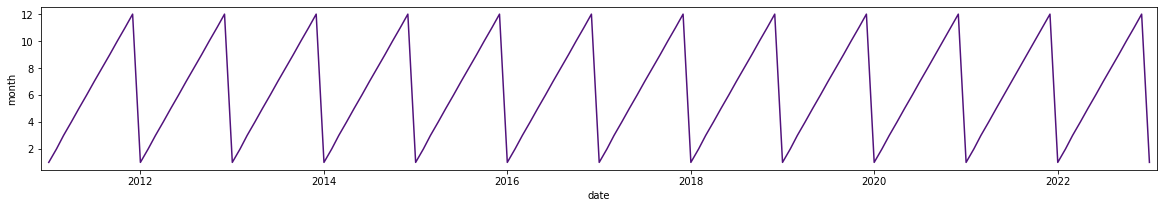

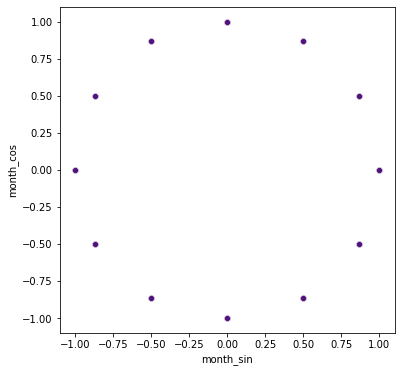

,date,rainfall,year,month,day,day_of_year,week_of_year,quarter,season,month_sin,month_cos
0,2011-01-01 00:30:00,3.856636,2011,1,1,1,52,1,1,5.000000e-01,8.660254e-01
1,2011-02-01 00:30:00,2.524517,2011,2,1,32,5,1,1,8.660254e-01,5.000000e-01
2,2011-03-01 00:30:00,7.338056,2011,3,1,60,9,1,2,1.000000e+00,6.123234e-17
3,2011-04-01 00:30:00,6.712648,2011,4,1,91,13,2,2,8.660254e-01,-5.000000e-01
4,2011-05-01 00:30:00,5.783099,2011,5,1,121,17,2,2,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...
135,2022-09-01 00:30:00,21.172812,2022,9,1,244,35,3,4,-1.000000e+00,-1.836970e-16
136,2022-10-01 00:30:00,4.095653,2022,10,1,274,39,4,4,-8.660254e-01,5.000000e-01
137,2022-11-01 00:30:00,7.641925,2022,11,1,305,44,4,4,-5.000000e-01,8.660254e-01
138,2022-12-01 00:30:00,10.460114,2022,12,1,335,48,4,1,-2.449294e-16,1.000000e+00


In [9]:
rdf_box2['year'] = pd.DatetimeIndex(rdf_box2['date']).year
rdf_box2['month'] = pd.DatetimeIndex(rdf_box2['date']).month
rdf_box2['day'] = pd.DatetimeIndex(rdf_box2['date']).day
rdf_box2['day_of_year'] = pd.DatetimeIndex(rdf_box2['date']).dayofyear
rdf_box2['week_of_year'] = pd.DatetimeIndex(rdf_box2['date']).weekofyear
rdf_box2['quarter'] = pd.DatetimeIndex(rdf_box2['date']).quarter
rdf_box2['season'] = rdf_box2['month'] % 12 // 3 + 1

rdf_box2[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=rdf_box2['date'], y=rdf_box2['month'], color=p[0])
ax.set_xlim([date(2010, 12, 1), date(2023, 1, 31)])
plt.show()

month_in_year = 12
rdf_box2['month_sin'] = np.sin(2*np.pi*rdf_box2['month']/month_in_year)
rdf_box2['month_cos'] = np.cos(2*np.pi*rdf_box2['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=rdf_box2.month_sin, y=rdf_box2.month_cos, color=p[0])
plt.show()


rdf_box2

Seasonal analysis

* level
* trend
* seasonality
* residuals

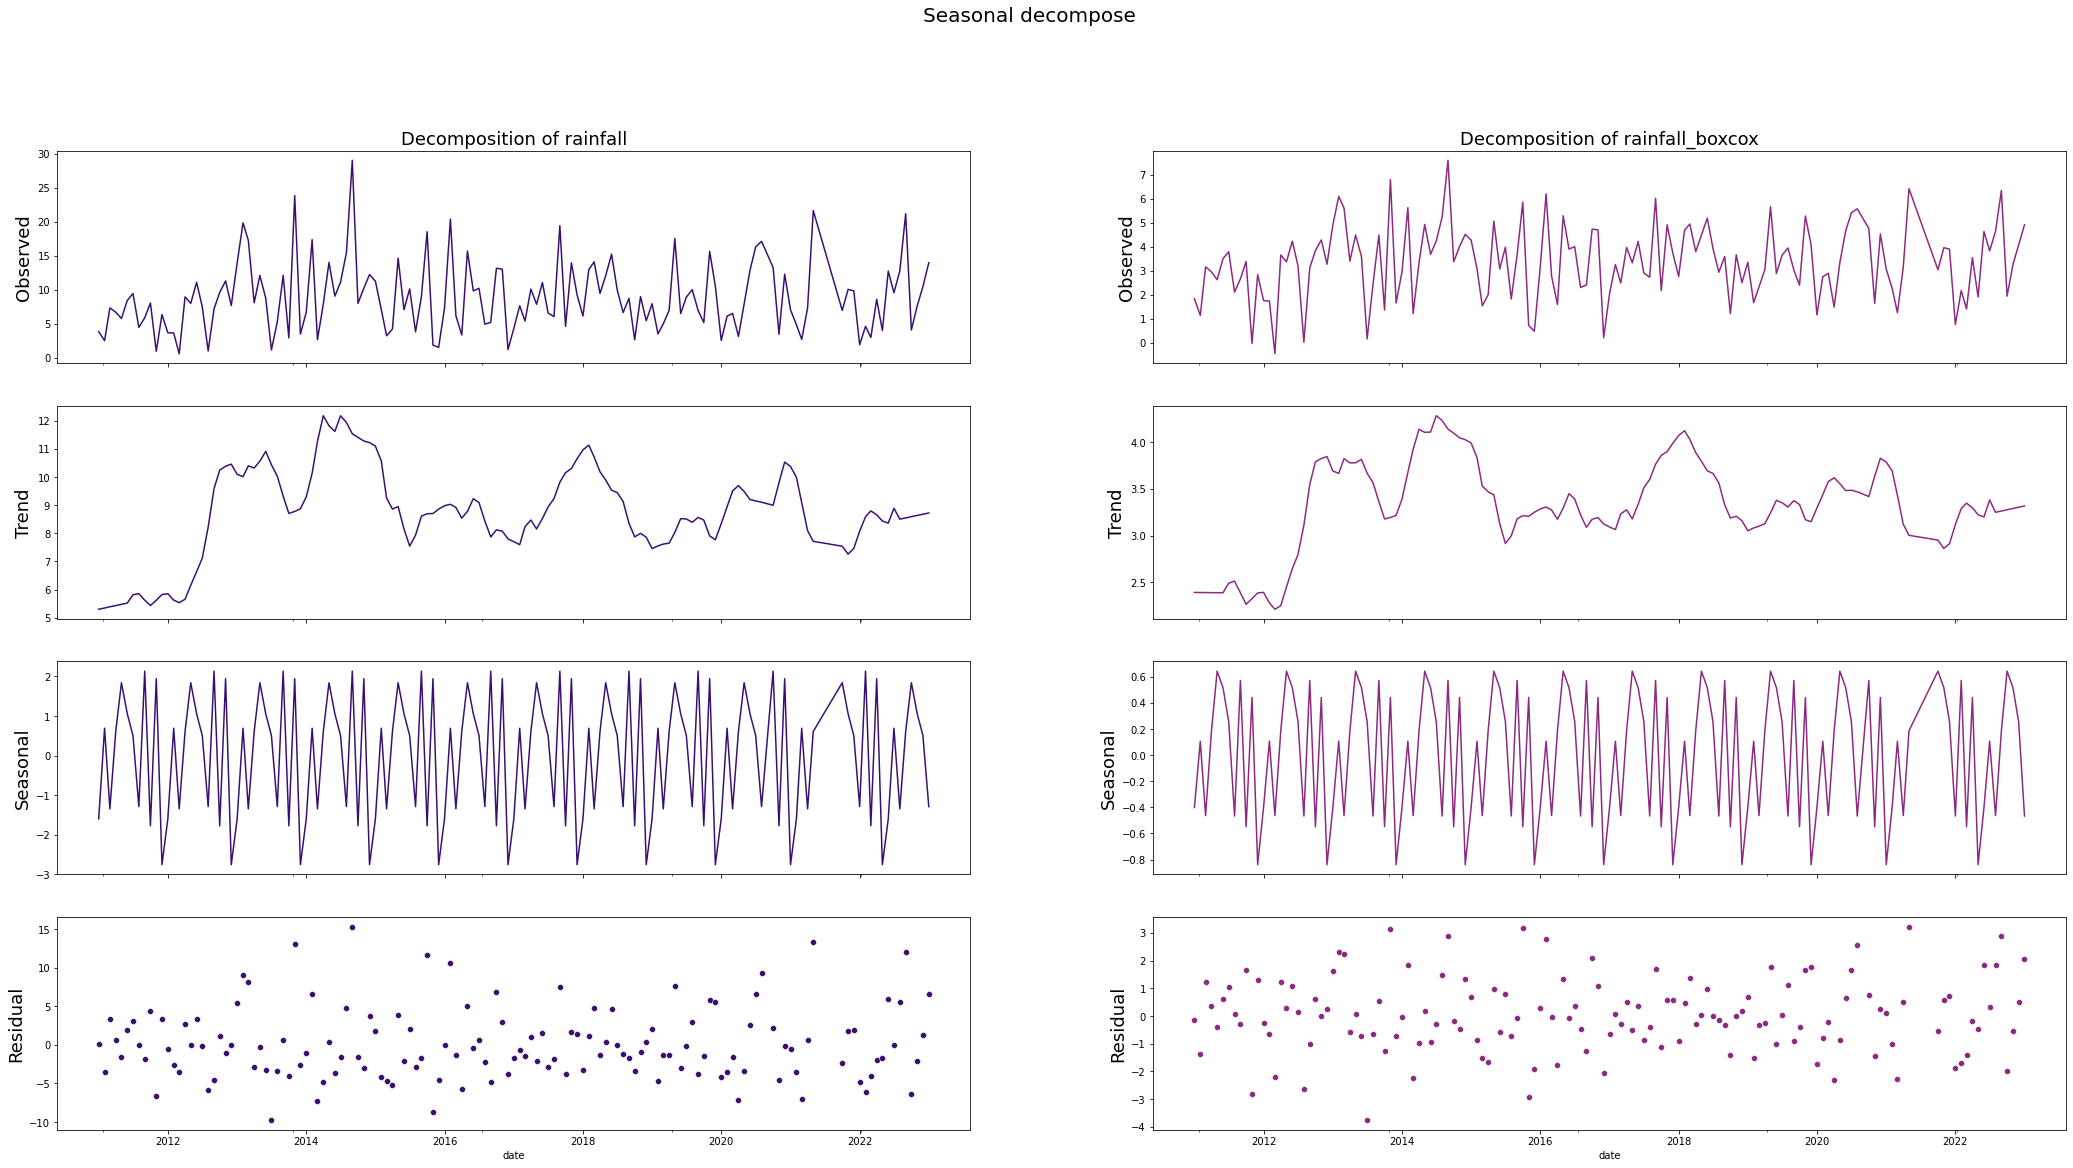

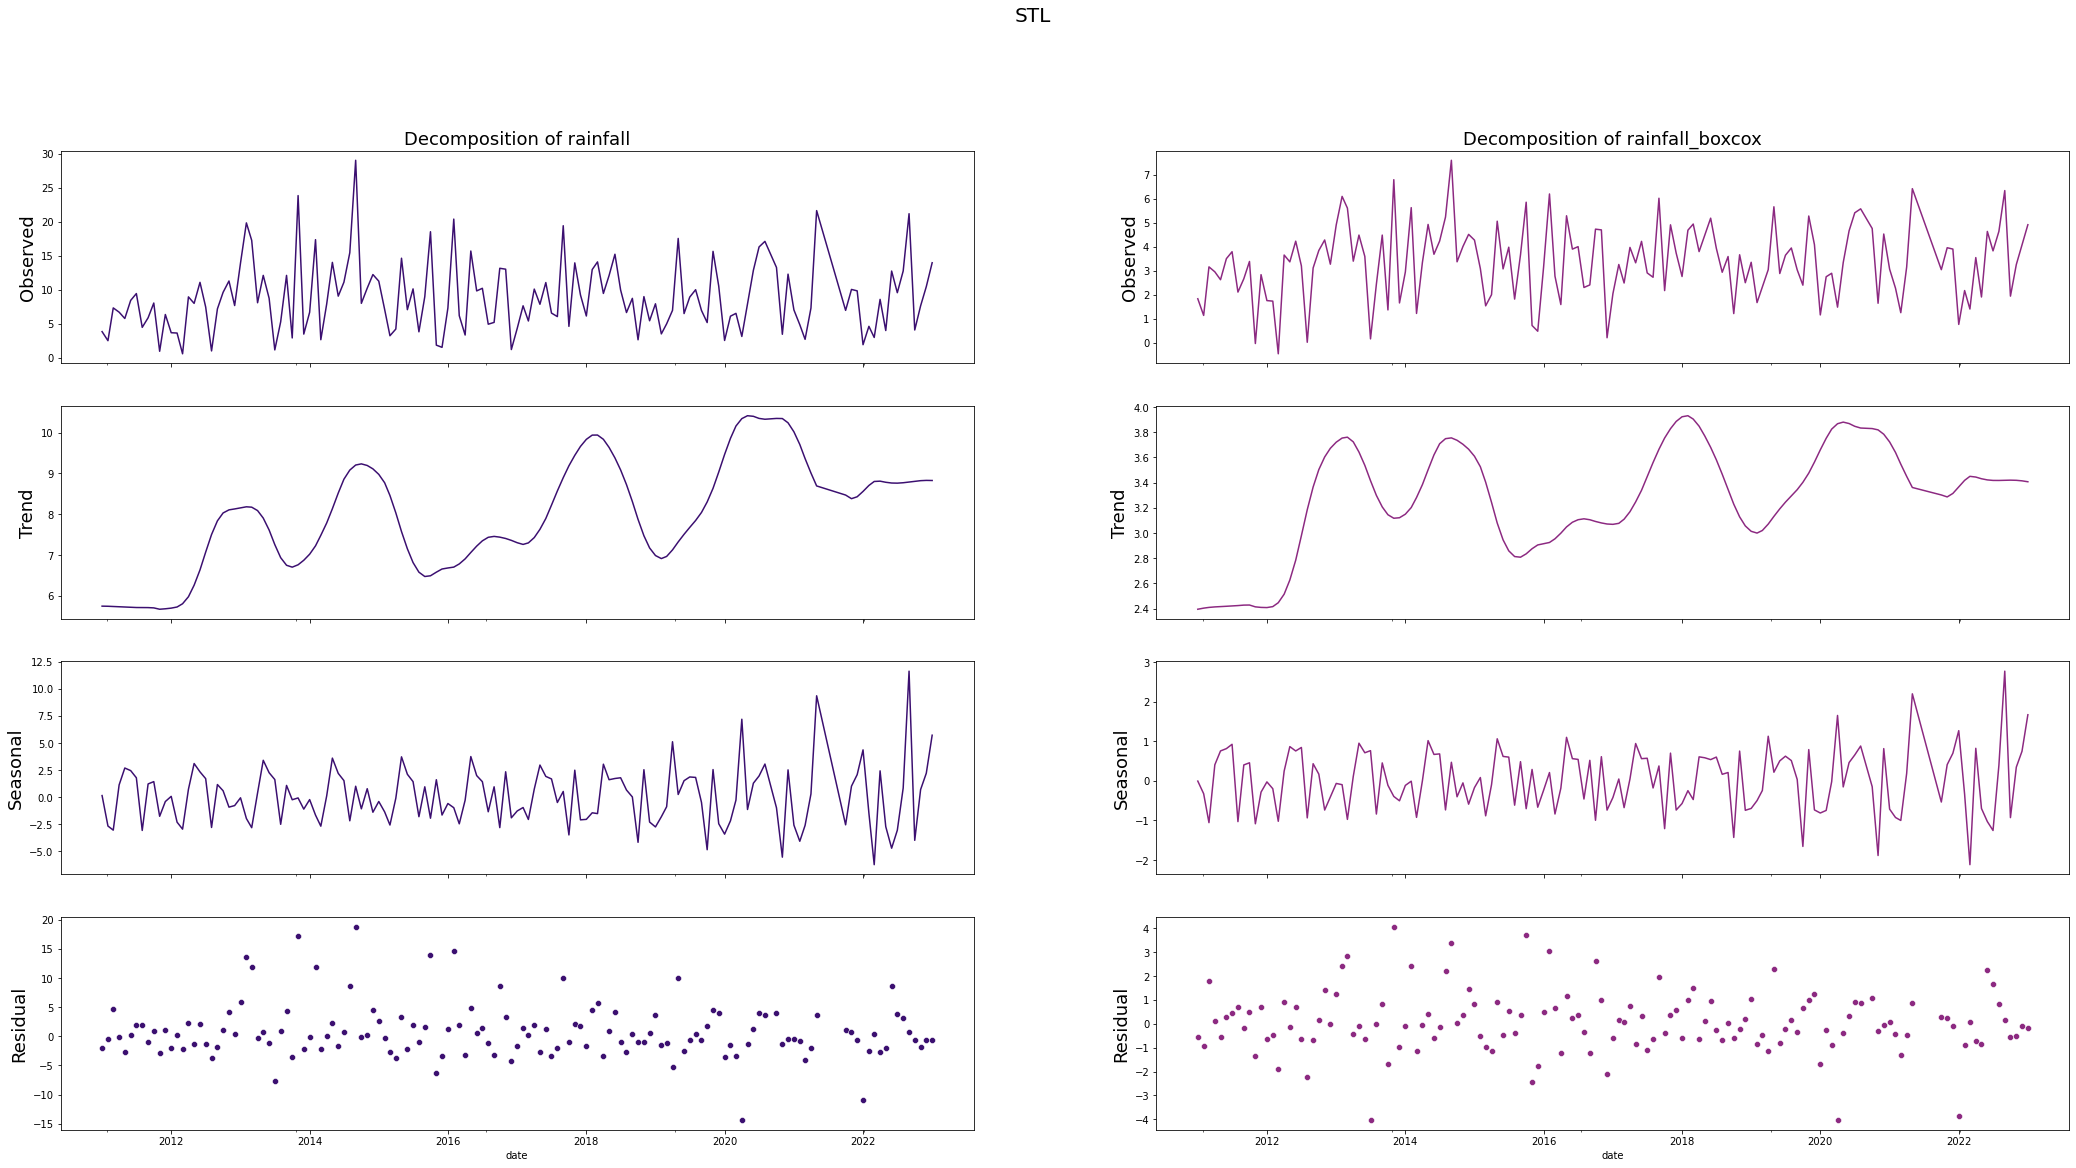

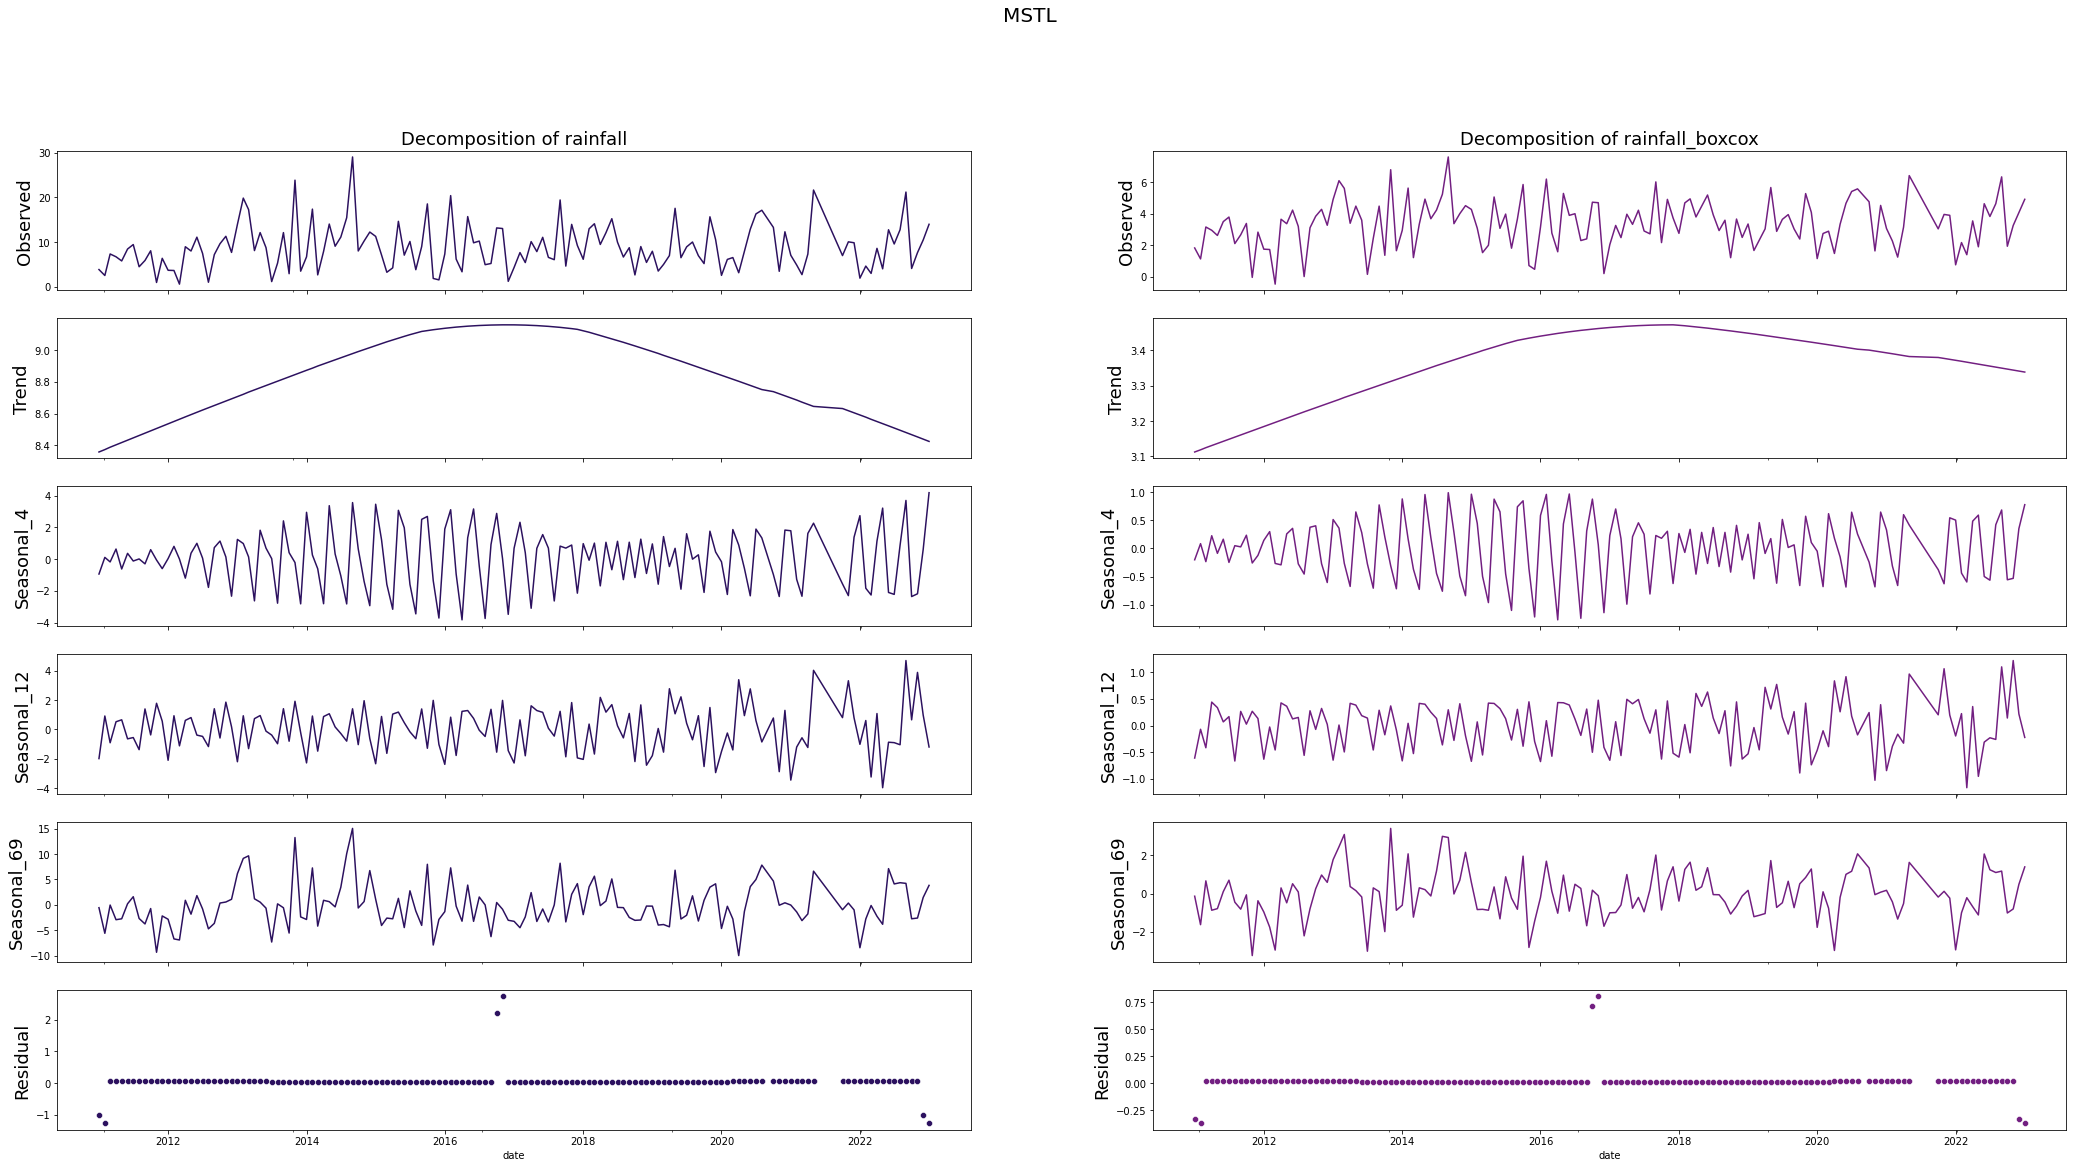

In [10]:
rdf_box['rainfall_boxcox'] = rdf_boxcox.rainfall

model='additive' #'multiplicative'


# seasonal decompose
fig, ax = plt.subplots(nrows=4,ncols=2,sharex=True, figsize=(36,20))
p = sns.color_palette('magma',4)
fig.suptitle('Seasonal decompose', fontsize=20)
for i, column in enumerate(['rainfall','rainfall_boxcox']):
    
    decomp = seasonal_decompose(rdf_box[column], period=12, model='additive', extrapolate_trend='freq')
    rdf_box[f'{column}_trend'] = decomp.trend
    rdf_box[f'{column}_seasons'] = decomp.seasonal

    ax[0,i].set_title(f'Decomposition of {column}', fontsize=18)
    decomp.observed.plot(ax=ax[0,i], legend=False, color=p[i])
    ax[0,i].set_ylabel('Observed', fontsize=18)

    decomp.trend.plot(ax=ax[1,i], legend=False, color=p[i])
    ax[1,i].set_ylabel('Trend', fontsize=18)

    decomp.seasonal.plot(ax=ax[2,i], legend=False, color=p[i])
    ax[2,i].set_ylabel('Seasonal', fontsize=18)

#     decomp.resid.plot(ax=ax[3,i], legend=False, color=p[i])
#     ax[3,i].set_ylabel('Residual', fontsize=18)
    
    sns.scatterplot(x=rdf_box.index, y=decomp.resid, ax=ax[3,i], color=p[i])
    ax[3,i].set_ylabel('Residual', fontsize=18)

    
# STL
fig, ax = plt.subplots(nrows=4,ncols=2,sharex=True, figsize=(36,20))
p = sns.color_palette('magma',4)
fig.suptitle('STL',fontsize=20)
for i, column in enumerate(['rainfall','rainfall_boxcox']):
    
    stl = STL(rdf_box[column], period=12, seasonal=13, robust=True)
    stl_decomp = stl.fit()
    
    rdf_box[f'{column}_stl_trend'] = stl_decomp.trend
    rdf_box[f'{column}_stl_seasons'] = stl_decomp.seasonal
    
    ax[0,i].set_title(f'Decomposition of {column}', fontsize=18)
    stl_decomp.observed.plot(ax=ax[0,i], legend=False, color=p[i])
    ax[0,i].set_ylabel('Observed', fontsize=18)

    stl_decomp.trend.plot(ax=ax[1,i], legend=False, color=p[i])
    ax[1,i].set_ylabel('Trend', fontsize=18)

    stl_decomp.seasonal.plot(ax=ax[2,i], legend=False, color=p[i])
    ax[2,i].set_ylabel('Seasonal', fontsize=18)

    sns.scatterplot(x=rdf_box.index, y=stl_decomp.resid, ax=ax[3,i], color=p[i])
    ax[3,i].set_ylabel('Residual', fontsize=18)



# MSTL
periods = [4,12, 6*12 -3]

fig, ax = plt.subplots(nrows=3 + len(periods),
                       ncols=2,
                       sharex=True, 
                       figsize=(36,20))

p = sns.color_palette('magma',5)

fig.suptitle('MSTL',fontsize=20)
for i, column in enumerate(['rainfall','rainfall_boxcox']):
    
    
    mstl = MSTL(rdf_box[column], periods=periods)#, seasonal=13, robust=True)
    mstl_decomp = mstl.fit()
    
#     mstl_decomp.plot()
        
    rdf_box[f'{column}_mstl_trend'] = mstl_decomp.trend
    for j,per in enumerate(periods):
        rdf_box[f'{column}_mstl_seasonal_{per}'] = mstl_decomp.seasonal[f'seasonal_{per}']
        mstl_decomp.seasonal[f'seasonal_{per}'].plot(ax=ax[2+j,i], legend=False, color=p[i])
        ax[2+j,i].set_ylabel(f'Seasonal_{per}', fontsize=18)

    rdf_box[f'{column}_mstl_resid'] = mstl_decomp.resid
    
    ax[0,i].set_title(f'Decomposition of {column}', fontsize=18)
    mstl_decomp.observed.plot(ax=ax[0,i], legend=False, color=p[i])
    ax[0,i].set_ylabel('Observed', fontsize=18)

    mstl_decomp.trend.plot(ax=ax[1,i], legend=False, color=p[i])
    ax[1,i].set_ylabel('Trend', fontsize=18)

    sns.scatterplot(x=rdf_box.index, y=mstl_decomp.resid, ax=ax[3+j,i], color=p[i])
    ax[3+j,i].set_ylabel('Residual', fontsize=18)


Shift analysis

* corr
* differencing/stationarity

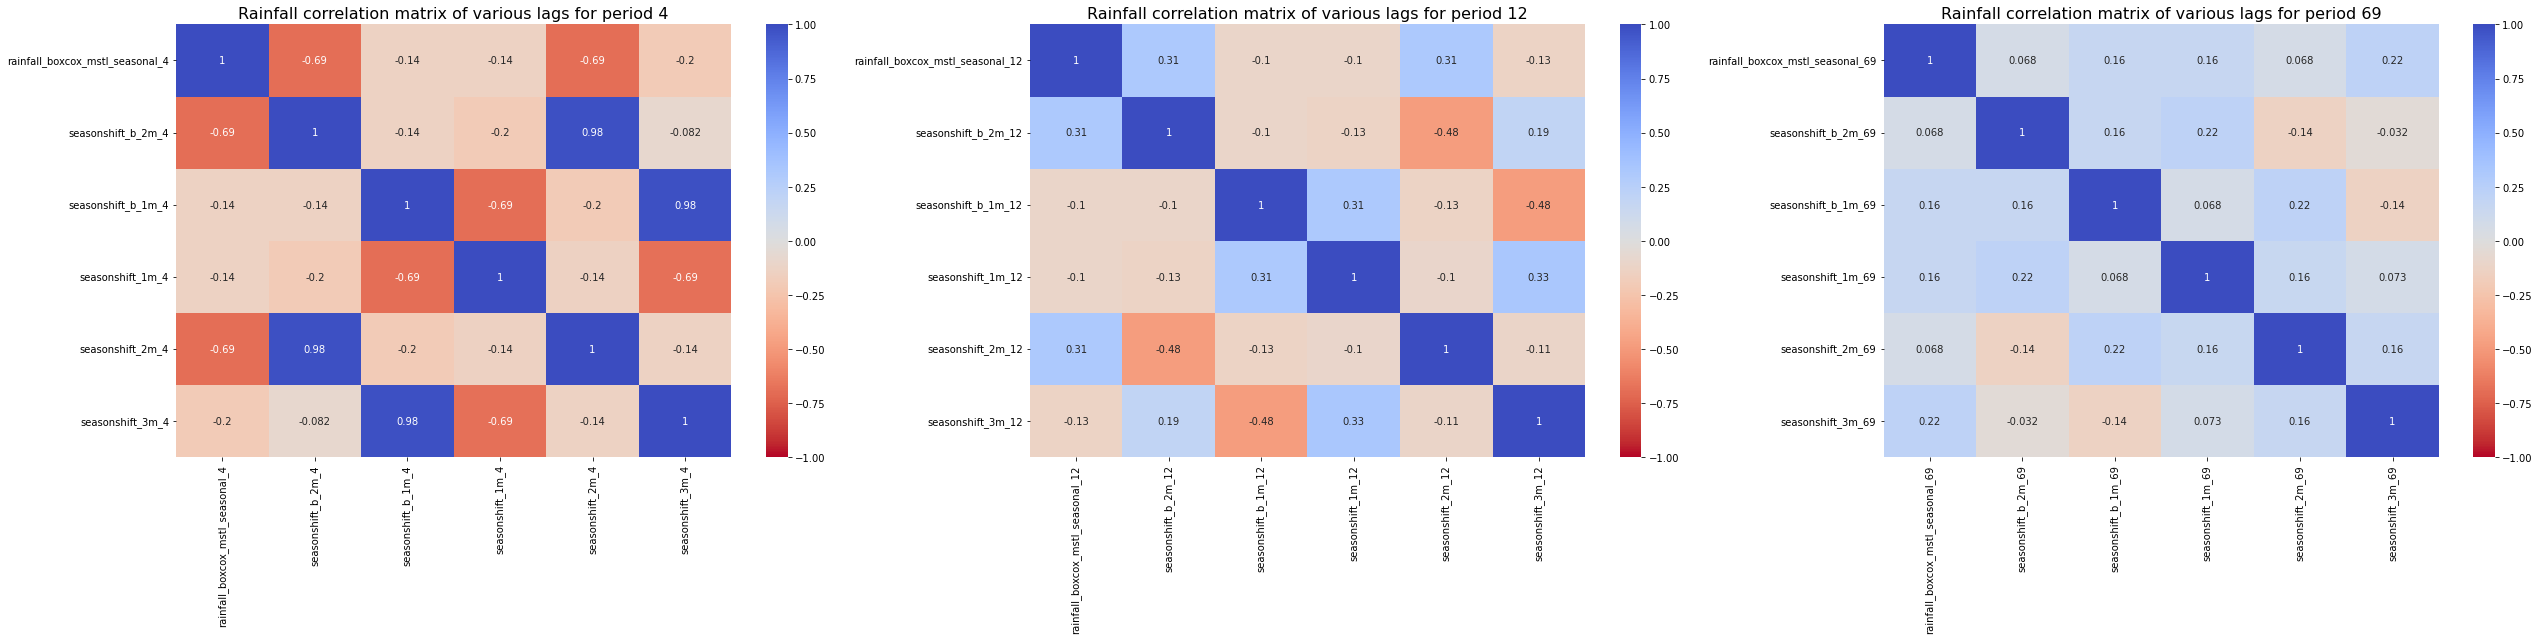

rainfall_boxcox Adfuller Statistic: -10.75
{'stationary': True}

rainfall_boxcox Kpss Statistic: 0.22
{'stationary': True}

rainfall_boxcox Zivot-Andrews Statistic: -11.34
{'stationary': True}



/home/creator/dev/i-views/TUM-Geoscience/gis-da/src/da/stats.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  np.array(stationarity_fn(x, **kwargs))[selectors]])


Text(0, 0.5, 'diff-2')

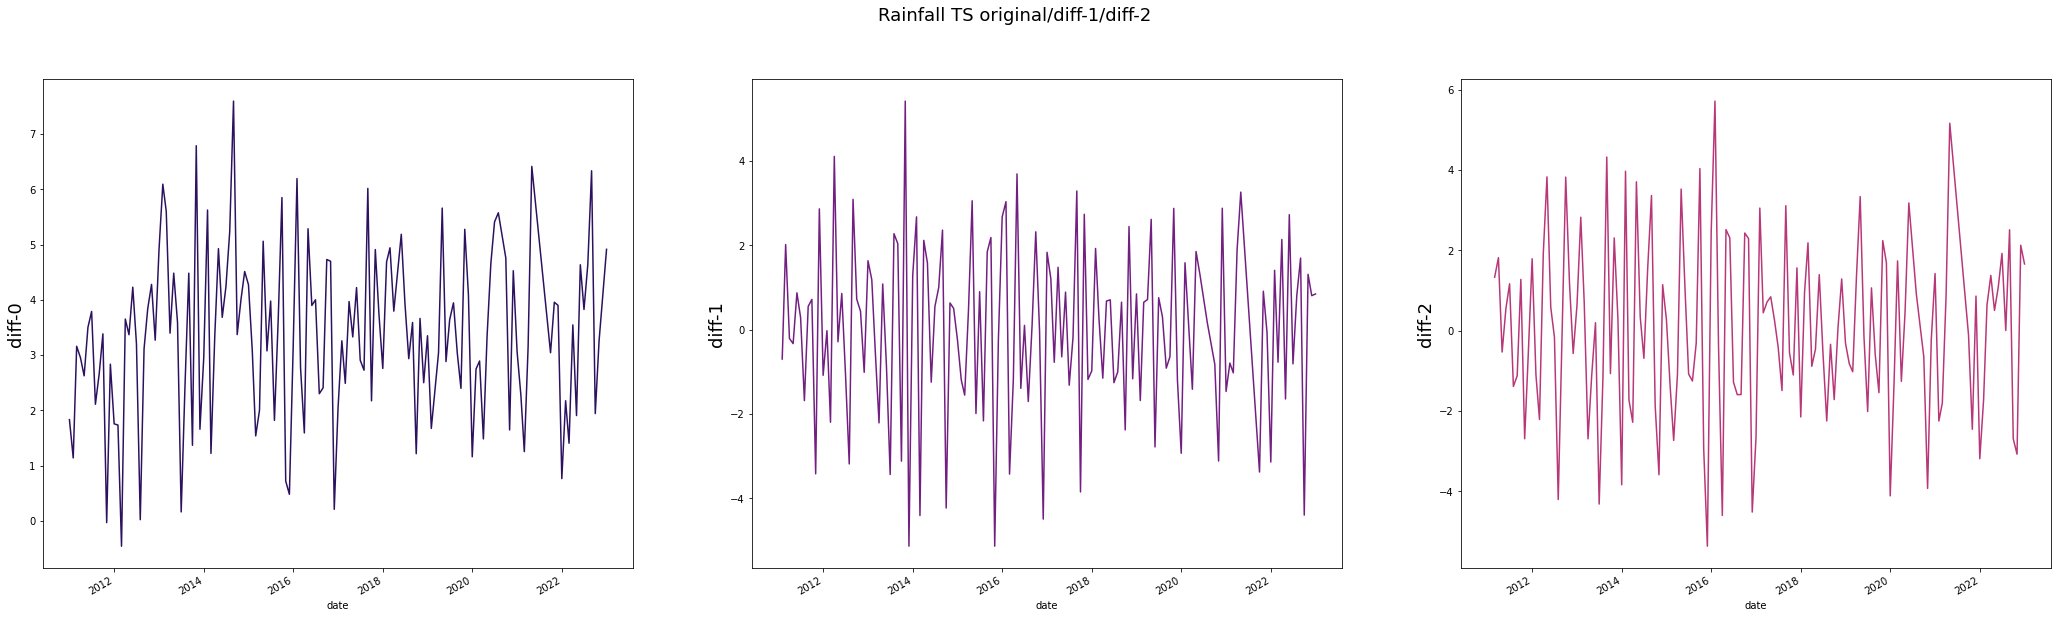

In [127]:
column = 'rainfall_boxcox'
method = 'mstl'

periods=[4,12,6*12-3]

mstl = MSTL(rdf_box[column], periods=periods)
mstl_decomp = mstl.fit()
trend     = mstl_decomp.trend
seasonals = mstl_decomp.seasonal
resid     = mstl_decomp.resid

shifted_cols = []
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(36, 9))

## CORR
for i,per in enumerate(periods):
    rdf_box[f'seasonal_{per}'] = seasonals[f'seasonal_{per}']
    rdf_box[f'seasonshift_b_2m_{per}'] = seasonals[f'seasonal_{per}'].shift(-2)
    rdf_box[f'seasonshift_b_1m_{per}'] = seasonals[f'seasonal_{per}'].shift(-1)
    rdf_box[f'seasonshift_1m_{per}'] = seasonals[f'seasonal_{per}'].shift(1)
    rdf_box[f'seasonshift_2m_{per}'] = seasonals[f'seasonal_{per}'].shift(2)
    rdf_box[f'seasonshift_3m_{per}'] = seasonals[f'seasonal_{per}'].shift(3)
    shifted_cols.append([f'{column}_{method}_seasonal_{per}', 
                         f'seasonshift_b_2m_{per}',
                         f'seasonshift_b_1m_{per}',
                         f'seasonshift_1m_{per}',
                         f'seasonshift_2m_{per}',
                         f'seasonshift_3m_{per}'])

    # correlation of lagged TS
    sns.heatmap(rdf_box[shifted_cols[-1]].corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[i])
    ax[i].set_title(f'Rainfall correlation matrix of various lags for period {per}', fontsize=16)


plt.tight_layout()
plt.show()
## STATIONARITY tests and differencing    
#### ADF test
dastats.check_stationarity(rdf_box, column,test_fn=dastats.sugars['Adfuller'],
                           withmsg=False, autolag='AIC')
#### KPSS test
dastats.check_stationarity(rdf_box, column, test_fn=dastats.sugars['Kpss'], 
                           withmsg=False, nlags='auto')
#### Zivot-Andrews test
dastats.check_stationarity(rdf_box, column, test_fn=dastats.sugars['Zivot-Andrews'], 
                           withmsg=False)

### DIFFERENCING
fig, ax = plt.subplots(nrows=1,
                       ncols=3,
                       sharex=True, 
                       figsize=(36,10))

p = sns.color_palette('magma',5)
fig.suptitle('Diff',fontsize=20)
fig.suptitle('Rainfall TS original/diff-1/diff-2',fontsize=18)
rdf_box[column].plot(ax=ax[0], legend=False, color=p[0])
ax[0].set_ylabel('diff-0', fontsize=18)

rdf_box[column].diff().plot(ax=ax[1], legend=False, color=p[1])
ax[1].set_ylabel('diff-1', fontsize=18)

rdf_box[column].diff(periods=2).plot(ax=ax[2], legend=False, color=p[2])
ax[2].set_ylabel('diff-2', fontsize=18)

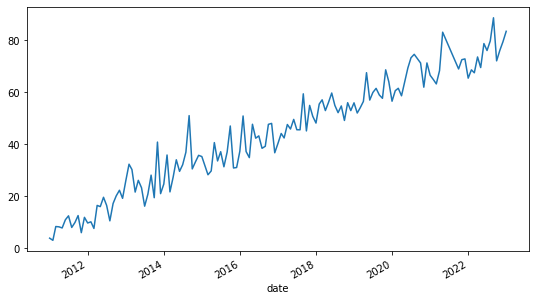


Original TS
rainfall-sdiff-0 Adfuller Statistic: -0.35
Critial Values:
   1%, -3.48
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58
p-value: 0.92

{'stationary': False}


Differenced by lag 1 TS
rainfall-sdiff-1 Adfuller Statistic: -7.66
Critial Values:
   1%, -3.48
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58
p-value: 0.00

{'stationary': True}


Differenced by lag 2 TS
rainfall-sdiff-2 Adfuller Statistic: -4.53
Critial Values:
   1%, -3.48
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58
p-value: 0.00

{'stationary': True}



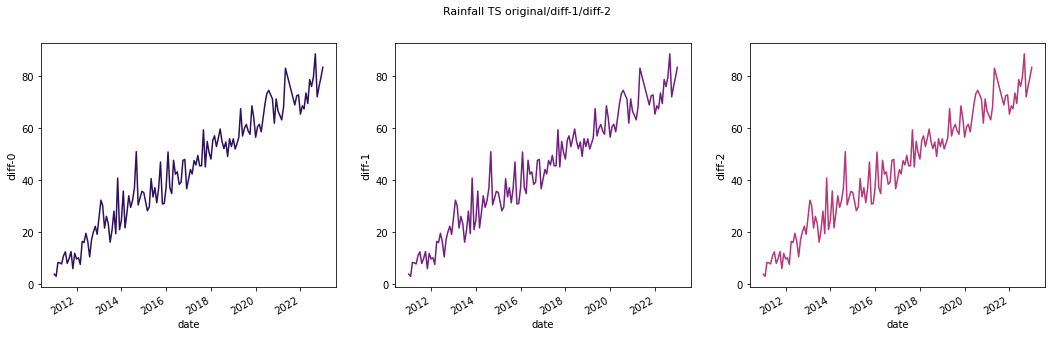

In [126]:
## example: of NON-Stationary TS
column = 'rainfall'
lags = [0,1,2]

rdf_box[f'{column}-non-stationary'] = rdf_box[column] + (np.power(np.arange(*rdf_box[column].shape),1) * 5e-1) # + 

rdf_box[f'{column}-non-stationary'].plot(figsize=(9,5))
plt.show()

fig, ax = plt.subplots(nrows=1,
                           ncols=len(lags),
                           sharex=True, 
                           figsize=(18,5))

p = sns.color_palette('magma',5)

for i,lag_i in enumerate(lags):
    title = f'Differenced by lag {lag_i} TS' if lag_i>0 else 'Original TS'
    print(f'\n{title}')

    rdf_box[f'{column}-sdiff-{lag_i}'] = rdf_box[f'{column}-non-stationary'].diff(periods=lag_i).shift(-lag_i) if lag_i>0 else rdf_box[f'{column}-non-stationary']
   
   
    #### ADF test
    dastats.check_stationarity(rdf_box, f'{column}-sdiff-{lag_i}',
                               test_fn=dastats.sugars['Adfuller'],
                               withmsg=True, autolag='AIC')

    ### differencing    
    fig.suptitle('Diff',fontsize=20)
    fig.suptitle('Rainfall TS original/diff-1/diff-2',fontsize=11)
    
    df.plot(ax=ax[i], legend=False, color=p[i])
    ax[i].set_ylabel(f'diff-{lag_i}', fontsize=11)


Shift analysis

* differenced signal analysis - hist, normality, seasonal decomp. and stationarity
* ACF (original/lag-1/lag-2)
* PACF (original/lag-1/lag-2)

                test-statistics        p-value
Shapiro diff-0         0.945185   2.538306e-05
        diff-1         0.980741   4.697802e-02
        diff-2         0.992477   6.777394e-01
K-S     diff-0         0.937064  1.401810e-168
        diff-1         0.429229   8.952497e-24
        diff-2         0.398366   2.862600e-20
rainfall_diff-1 Adfuller Statistic: -7.66
{'stationary': True}

rainfall_diff-1 Kpss Statistic: 0.10
{'stationary': True}

rainfall_diff-1 Zivot-Andrews Statistic: -7.91
{'stationary': True}

rainfall_diff-2 Adfuller Statistic: -4.53
{'stationary': True}

rainfall_diff-2 Kpss Statistic: 0.16
{'stationary': True}



/home/creator/dev/i-views/TUM-Geoscience/gis-da/src/da/stats.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  np.array(stationarity_fn(x, **kwargs))[selectors]])
/home/creator/dev/i-views/TUM-Geoscience/gis-da/src/da/stats.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  np.array(stationarity_fn(x, **kwargs))[selectors]])


rainfall_diff-2 Zivot-Andrews Statistic: -4.99
{'stationary': True}



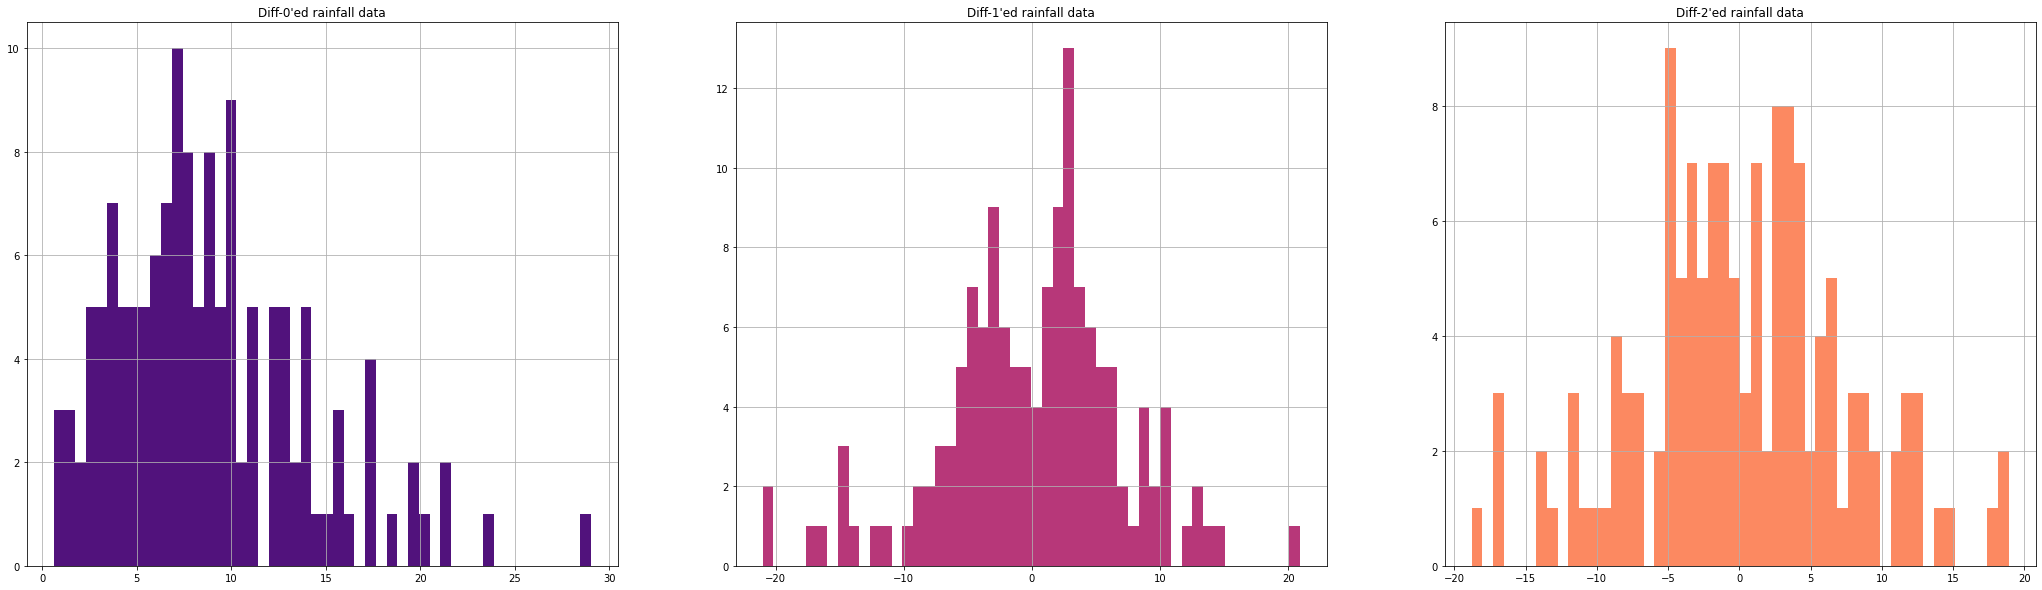

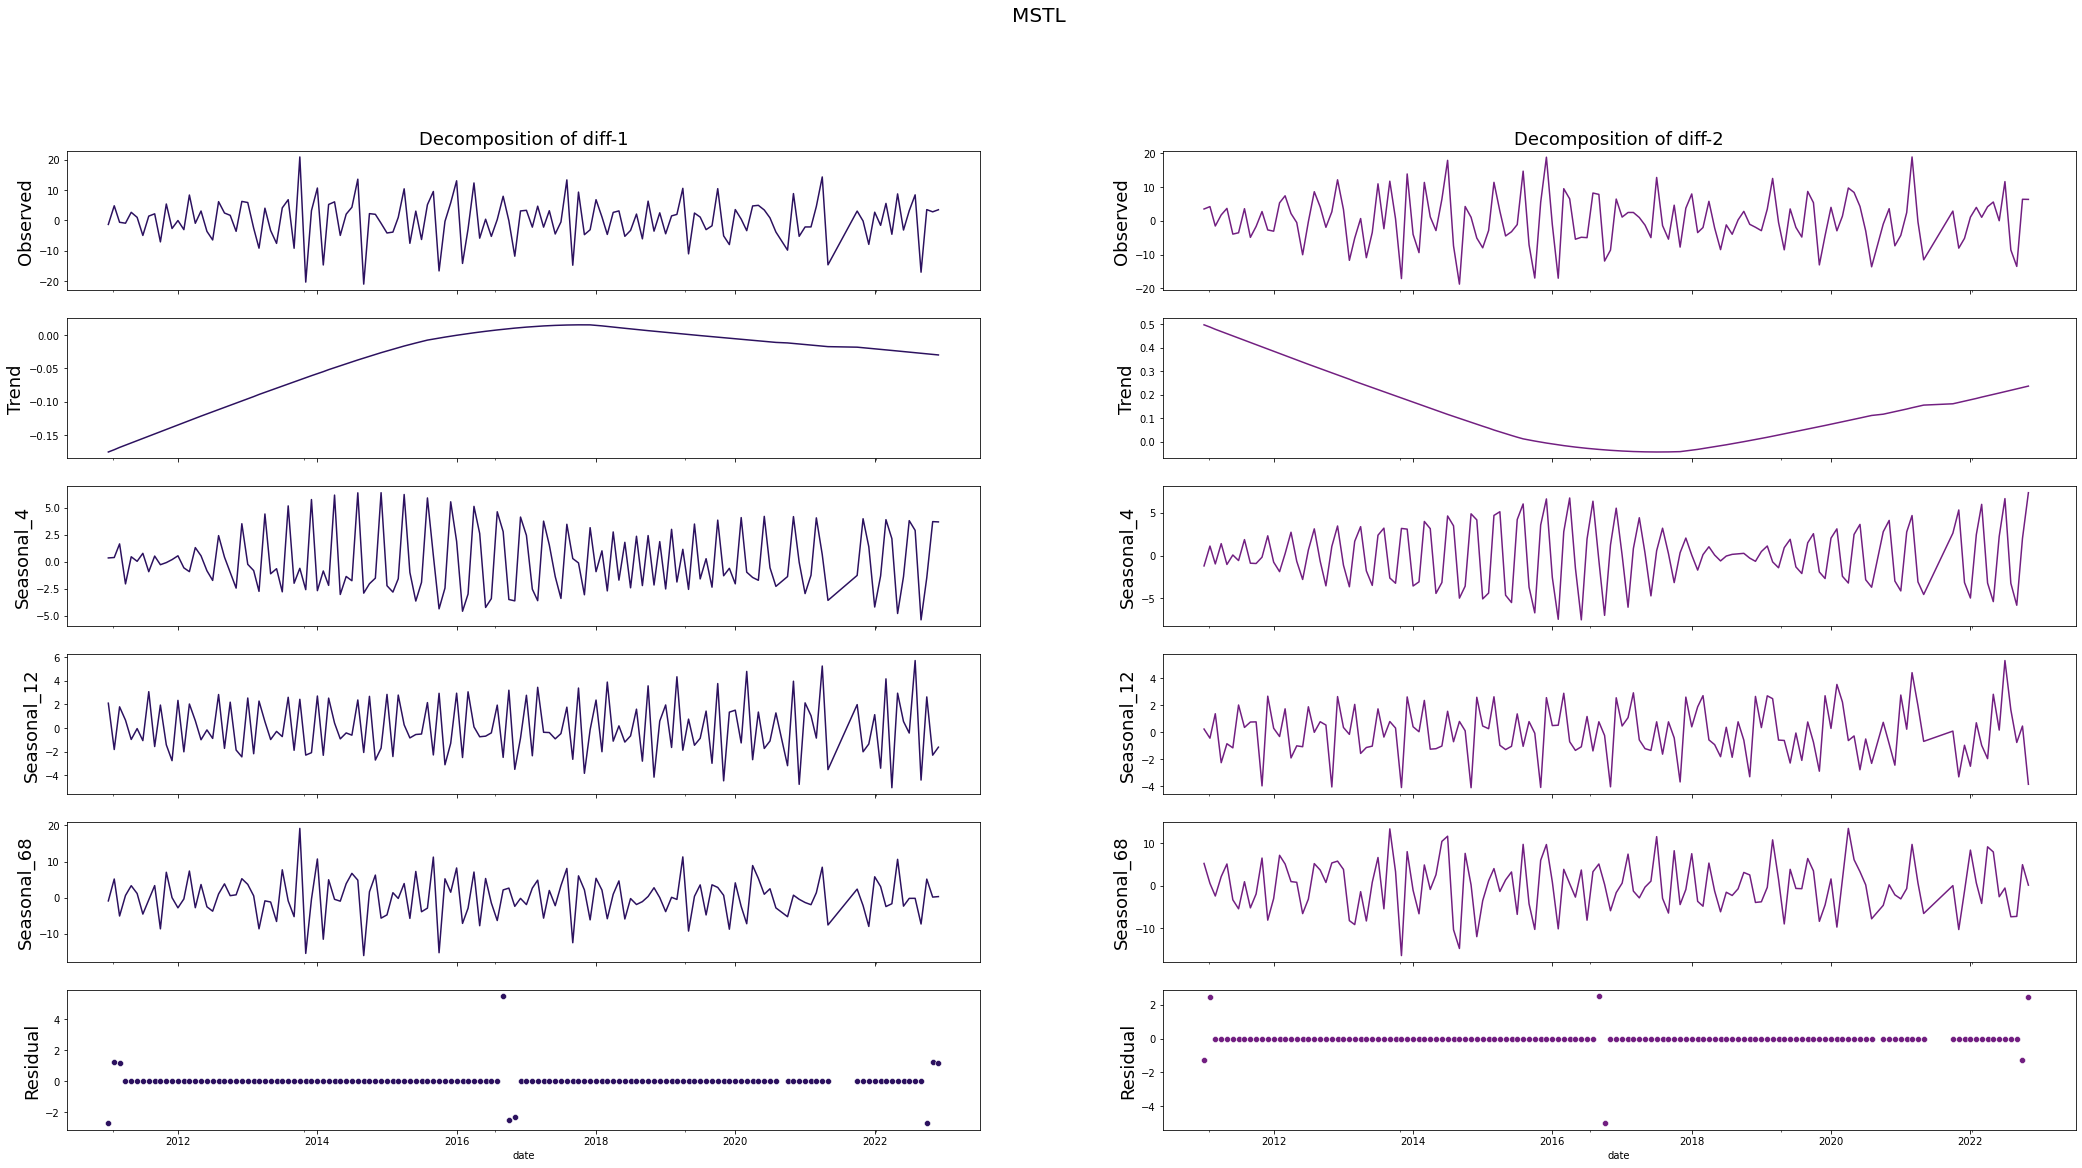

In [124]:
### Normality, sesonal decomposition, and stationarity tests for lag-N
lagNs = [0,1,2]
column = 'rainfall'
normality_results = {'Shapiro':{},'K-S':{}}

# Normality :TODO:TODO:TODO: all these were done in previous cells - put them in poython modules for this cell and just call the resulting API
fig, ax = plt.subplots(1,len(lagNs), figsize=(36, 10))
p = sns.color_palette('magma',len(lagNs))


for i,lagN in enumerate(lagNs):
    ### histograms
    rdf_box[f'{column}_diff-{lagN}'] = rdf_box[column].diff(periods=lagN).shift(-lagN).dropna() if i>0 else rdf_box[column]
    rdf_box[f'{column}_diff-{lagN}'].hist(bins=50, ax=ax[i], color=p[i])
    ax[i].set_title(f'Diff-{lagN}\'ed rainfall data')
    
    ### normality tests
    normality_results['Shapiro'][f'diff-{lagN}'] = shapiro(rdf_box[f'{column}_diff-{lagN}'].dropna())
    normality_results['K-S'][f'diff-{lagN}'] = kstest(rdf_box[f'{column}_diff-{lagN}'].dropna(), 'norm')

normality_results = walk(normality_results)
normality_results = pd.DataFrame.from_dict({(i,j): normality_results[i][j]
                                                for i in normality_results.keys() 
                                                for j in normality_results[i].keys()
                                                },
                                            orient='index')
print(normality_results)

# MSTL
periods = [4,12, 6*12-4]

fig, ax = plt.subplots(nrows=3 + len(periods),
                       ncols=2,
                       sharex=True, 
                       figsize=(36,20))

p = sns.color_palette('magma',5)

fig.suptitle('MSTL',fontsize=20)
for i, lagN in enumerate([1,2]):
    
    
    mstl = MSTL(rdf_box[f'{column}_diff-{lagN}'].dropna(), periods=periods)#, seasonal=13, robust=True)
    mstl_decomp = mstl.fit()
    
#     mstl_decomp.plot()
        
    rdf_box[f'diff-{lagN}_mstl_trend'] = mstl_decomp.trend
    for j,per in enumerate(periods):
        
        rdf_box[f'diff-{lagN}_mstl_seasonal_{per}'] = mstl_decomp.seasonal[f'seasonal_{per}']
        mstl_decomp.seasonal[f'seasonal_{per}'].plot(ax=ax[2+j,i], legend=False, color=p[i])
        ax[2+j,i].set_ylabel(f'Seasonal_{per}', fontsize=18)

    rdf_box[f'diff-{lagN}_mstl_resid'] = mstl_decomp.resid
    
    ax[0,i].set_title(f'Decomposition of diff-{lagN}', fontsize=18)
    mstl_decomp.observed.plot(ax=ax[0,i], legend=False, color=p[i])
    ax[0,i].set_ylabel('Observed', fontsize=18)

    mstl_decomp.trend.plot(ax=ax[1,i], legend=False, color=p[i])
    ax[1,i].set_ylabel('Trend', fontsize=18)

    sns.scatterplot(x=rdf_box.index[:-lagN], y=mstl_decomp.resid, ax=ax[3+j,i], color=p[i])
    ax[3+j,i].set_ylabel('Residual', fontsize=18)

## STATIONARITY tests and differencing
for lagN in [1,2]:    
    
    #### ADF test
    dastats.check_stationarity(rdf_box, f'{column}_diff-{lagN}',test_fn=dastats.sugars['Adfuller'],
                               withmsg=False, autolag='AIC')
    #### KPSS test
    dastats.check_stationarity(rdf_box, f'{column}_diff-{lagN}', test_fn=dastats.sugars['Kpss'], 
                               withmsg=False, nlags='auto')
    #### Zivot-Andrews test
    dastats.check_stationarity(rdf_box, f'{column}_diff-{lagN}', test_fn=dastats.sugars['Zivot-Andrews'], 
                               withmsg=False)


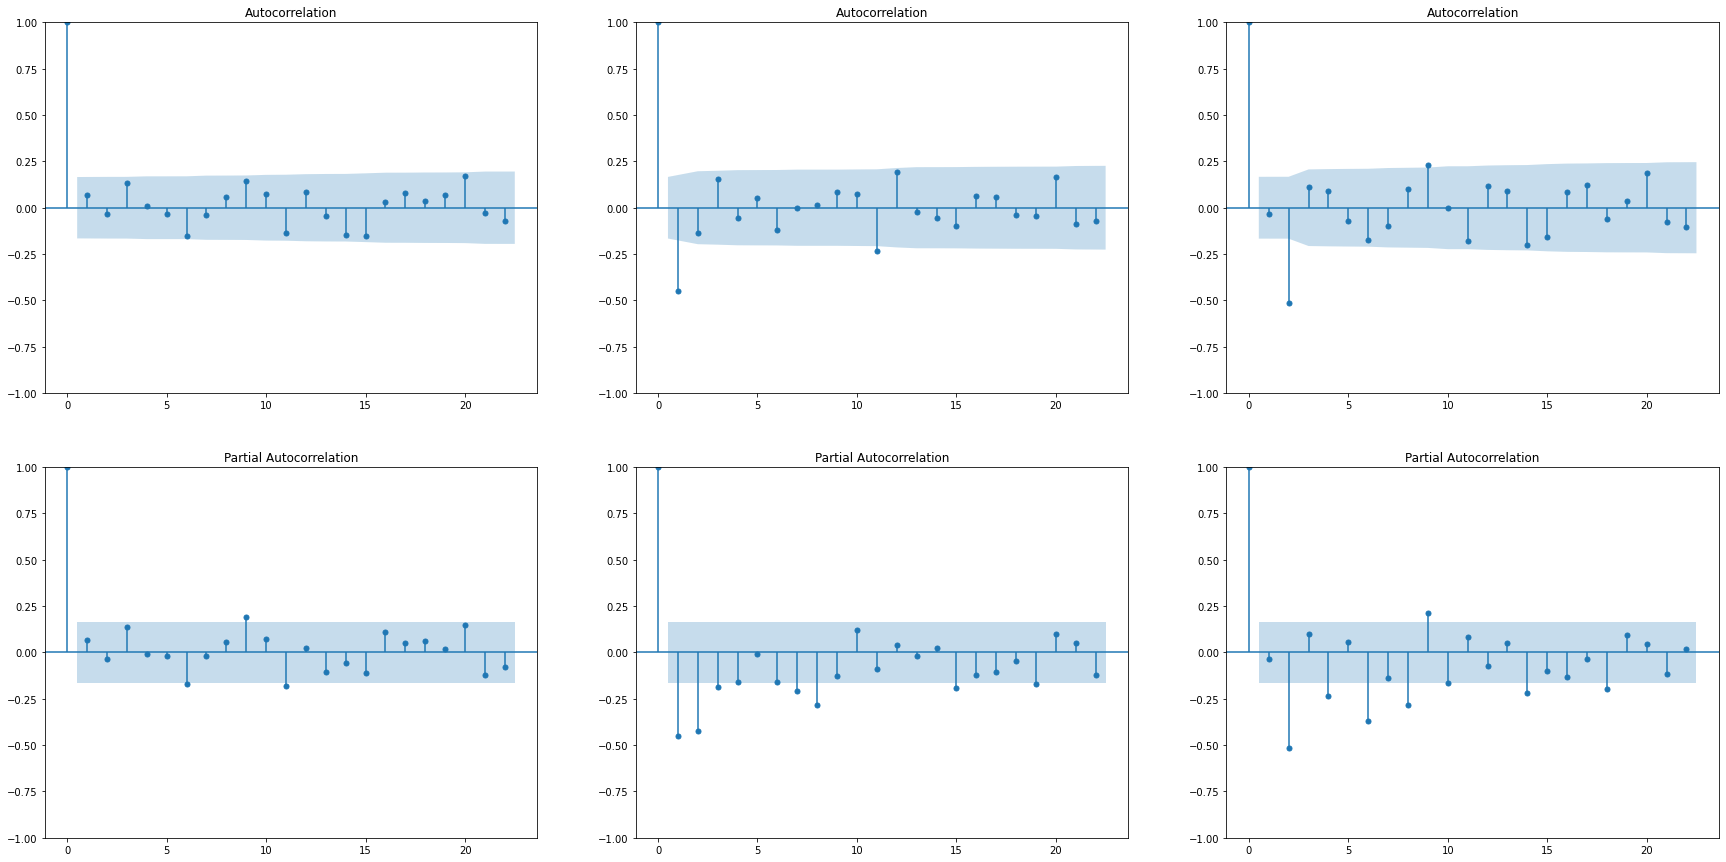

In [14]:
# ACF/PACF

lags = [0,1,2]
column = 'rainfall'

f, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))

for lag_i in lags:
    
    plot_acf(rdf_box[f'{column}_diff-{lag_i}'].dropna(), ax=ax[0,lag_i])
    plot_pacf(rdf_box[f'{column}_diff-{lag_i}'].dropna(), ax=ax[1, lag_i])


In [125]:
from importlib import reload
import src.da.stats as dastats

reload(dastats)


dastats.check_stationarity(rdf_box, f'{column}_diff-{lagN}', test_fn=dastats.sugars['Adfuller'], withmsg=True, autolag='AIC')



rainfall_diff-2 Adfuller Statistic: -4.53
Critial Values:
   1%, -3.48
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58
p-value: 0.00

{'stationary': True}



{'stationary': True}